In [1]:
from google.colab import drive


FOLDERNAME = 'damaged_structures_detector/images'

drive.mount('/content/drive', force_remount=True)

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler, RandomSampler, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageOps
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
from sklearn.metrics import confusion_matrix
import time

import seaborn as sns
from __future__ import print_function 
from __future__ import division
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cpu


Setup

In [0]:
%%capture
MODEL_PATH = "damaged_structures_detector/checkpoints/best_model.pth"
model = torch.load(MODEL_PATH, map_location=device)
model.to(device)
model.eval()

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3662, 0.3452, 0.3384],
                             std=[0.1552, 0.1500, 0.1475])
    ])

train_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'),transform = data_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = data_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'test'),transform = data_transform)


# Number of training examples
NUM_TRAIN = len(train_dataset)

# Number of Validation examples
NUM_VAL = len(val_dataset)

# Number of Test Examples
NUM_TEST = len(test_dataset)

# Batch Size for Training
BATCH_SIZE = 128


# Shuffle the Data with Random Samplers
train_indices = list(range(NUM_TRAIN))
np.random.shuffle(train_indices)

val_indices = list(range(NUM_VAL))
np.random.shuffle(val_indices)

test_indices = list(range(NUM_TEST))
np.random.shuffle(test_indices)

train_idx, val_idx, test_idx = train_indices, val_indices, test_indices


train_sampler = SubsetRandomSampler(train_idx)
val_sampler   = SubsetRandomSampler(val_idx)
test_sampler  = SubsetRandomSampler(test_idx)


## Dataloaders

loader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers = 16) ## shuffle = True if sampler does not work 

loader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers = 16)  ## shuffle = True

loader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, num_workers = 16)



dataloaders_dict = {}
dataloaders_dict.update( {'train' : loader_train} )
dataloaders_dict.update( {'val' : loader_val} )
dataloaders_dict.update( {'test' : loader_test} )

In [0]:
MEAN = [0.3662, 0.3452, 0.3384] # [0.3662, 0.3452, 0.3384]
STD  = [0.1552, 0.1500, 0.1475] # [0.1552, 0.1500, 0.1475]

test_transforms_print = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor()
                                     ])

test_transforms_predict = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=MEAN,
                                                            std=STD)
                                     ])

Visualize Model's Predictions

In [0]:
def get_random_images(num):
    data = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = test_transforms_print)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, data.classes

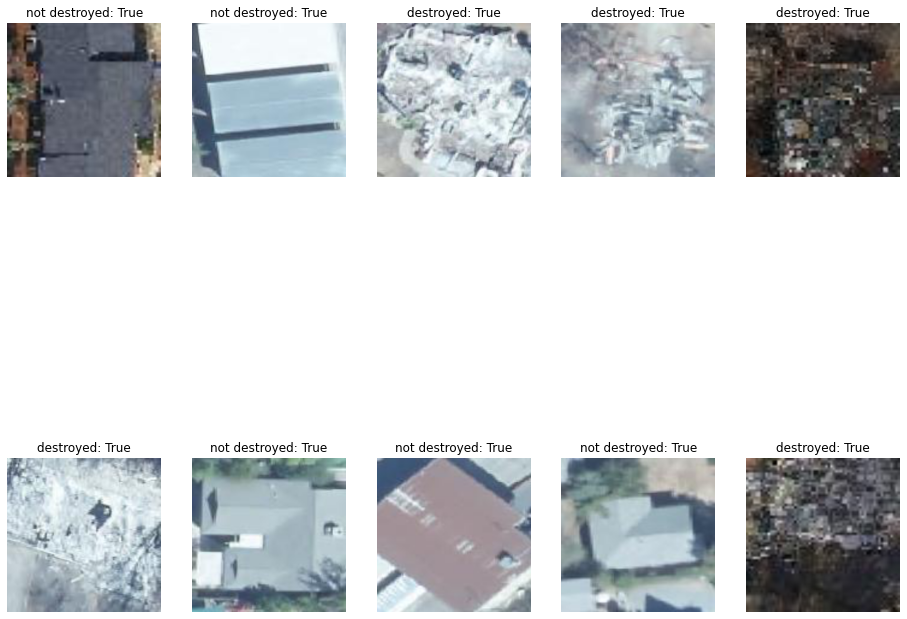

In [8]:
# Import Some Random Images
to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(10)
fig=plt.figure(figsize=(16, 16))
gpu_images = images.clone()


for i in range(gpu_images.shape[0]):
    gpu_images[i,:,:,:] = test_transforms_predict(gpu_images[i,:,:,:])

gpu_images = gpu_images.to(device)

# Make predictions on them
outputs = model(gpu_images)
_, preds = torch.max(outputs, 1)
preds = preds.data.cpu().numpy()

labels = labels.cpu().numpy()


# Plot the results
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = preds[ii]
    cor_class = classes[index]
    sub = fig.add_subplot(2, len(images)/2, ii+1)
    fig.subplots_adjust(hspace=0.0, wspace=0.2)
    res = int(labels[ii]) == index
    if cor_class == classes[0]:
      sub.set_title(str(cor_class.split('_')[1]) + " " + cor_class.split('_')[2] + ": " + str(res))
    else:
      sub.set_title(str(cor_class.split('_')[1]) + ": " + str(res))
    plt.axis('off')
    plt.imshow(image)
    #plt.savefig('Model Predictions.png')
plt.show()

Confusion Matrix, Precision, Recall, F1 Score

In [9]:
start = time.time()

CF = np.zeros((2,2))
wrong_validation_examples = []
i = 0

for examples, true_labels in dataloaders_dict['val']:
  examples = examples.to(device)
  i += 1
  print('batch number: ', i)

  with torch.no_grad():
    outputs = model(examples)
    _, preds = torch.max(outputs, 1)


  wrong_indices = np.nonzero(true_labels.numpy() - preds.data.cpu().numpy())
  wrong_validation_examples.append((examples.cpu().numpy()[wrong_indices] , true_labels.numpy()[wrong_indices]))
  CF += confusion_matrix(true_labels.numpy(), preds.data.cpu().numpy())


print(CF)

end = time.time()
print('total time: ', end - start)

batch number:  1
batch number:  2
batch number:  3
batch number:  4
batch number:  5
batch number:  6
batch number:  7
batch number:  8
batch number:  9
batch number:  10
batch number:  11
batch number:  12
batch number:  13
batch number:  14
batch number:  15
batch number:  16
batch number:  17
batch number:  18
batch number:  19
batch number:  20
batch number:  21
batch number:  22
batch number:  23
batch number:  24
batch number:  25
batch number:  26
batch number:  27
batch number:  28
batch number:  29
batch number:  30
batch number:  31
batch number:  32
batch number:  33
batch number:  34
batch number:  35
batch number:  36
batch number:  37
batch number:  38
batch number:  39
batch number:  40
batch number:  41
batch number:  42
batch number:  43
[[2558.   79.]
 [ 108. 2658.]]
total time:  532.1727349758148


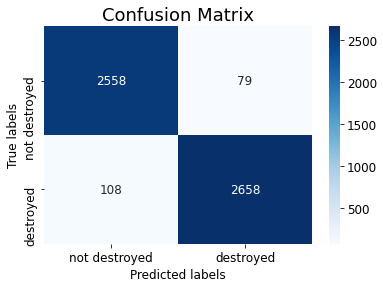

In [62]:
ax= plt.subplot()
sns.heatmap(CF, annot=True, ax = ax, cmap='Blues', fmt='g'); #annot=True to annotate cells

# labels, title and ticks
plt.rc('font', size=15)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not destroyed', 'destroyed']); ax.yaxis.set_ticklabels(['not destroyed', 'destroyed']);
plt.savefig('CM.png')

In [11]:
tp = CF[1,1]
tn = CF[0,0]
fp = CF[0,1]
fn = CF[1,0]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F1 = 2 * tp / (2*tp + fp + fn)
print('Accuracy: ', (CF[0,0] + CF[1,1]) / (CF[0,1] + CF[1,0] + CF[0,0] + CF[1,1]))
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', F1)

Accuracy:  0.9653895983712752
Precision:  0.9711362805991962
Recall:  0.9609544468546638
F1 Score:  0.9660185353443577


Visualize some wrong predictions

In [0]:
wrong_validation_examples_tuple = []
for ii in range(len(wrong_validation_examples)):
  for jj in range(len(wrong_validation_examples[ii][0])):
    wrong_validation_examples_tuple.append((wrong_validation_examples[ii][0][jj], wrong_validation_examples[ii][1][jj]))

In [13]:
original_wrong_images = []
original_wrong_labels = []

for i in range(len(wrong_validation_examples_tuple)):
    reconstructed_image = np.zeros((3, 224, 224))
    reconstructed_image[0, :, :] = wrong_validation_examples_tuple[i][0][0, :, :] * STD[0] + MEAN[0]
    reconstructed_image[1, :, :] = wrong_validation_examples_tuple[i][0][1, :, :] * STD[1] + MEAN[1]
    reconstructed_image[2, :, :] = wrong_validation_examples_tuple[i][0][2, :, :] * STD[2] + MEAN[2]
    original_wrong_images.append(to_pil(torch.tensor(np.float32(reconstructed_image))))
    original_wrong_labels.append(wrong_validation_examples_tuple[i][1])

print('total wrong examples: ',len(original_wrong_labels))

total wrong examples:  187


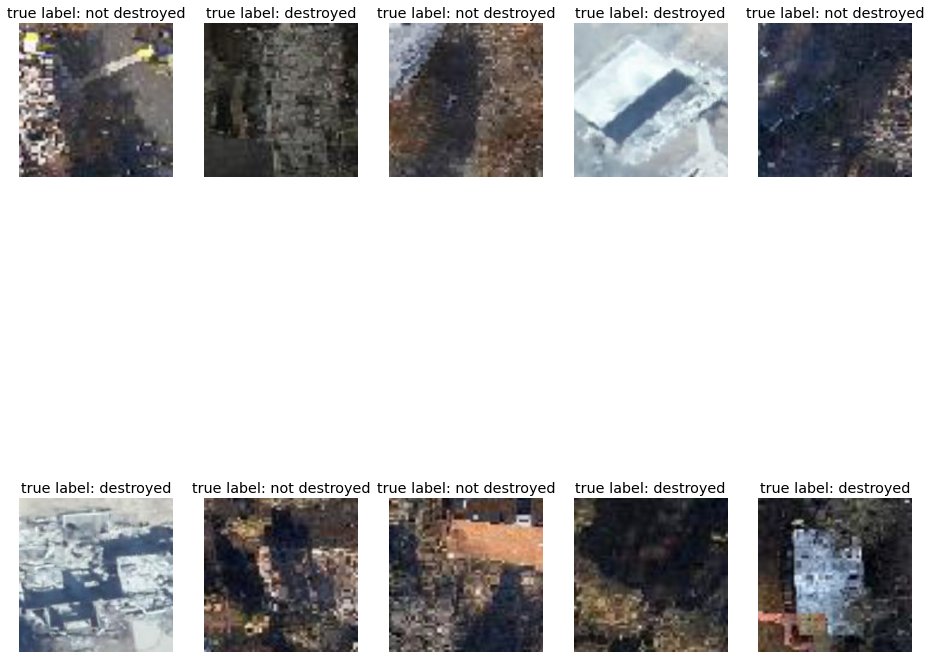

In [40]:
num_images_to_print = 10
indices = list(range(len(wrong_validation_examples_tuple)))
np.random.shuffle(indices)
idx = indices[:num_images_to_print]
images_to_print = []
labels_to_print = []

for ii in range(len(idx)):
  images_to_print.append(original_wrong_images[idx[ii]])
  labels_to_print.append(original_wrong_labels[idx[ii]])

fig=plt.figure(figsize=(16, 16))
classes = train_dataset.classes

for ii in range(num_images_to_print):
    image = images_to_print[ii]
    label = labels_to_print[ii]
    cor_class = classes[label]
    plt.rc('font', size=12)
    sub = fig.add_subplot(2, num_images_to_print/2, ii+1)
    if cor_class == classes[0]:
      sub.set_title( 'true label' + ': ' + str(cor_class.split('_')[1]) + " " + cor_class.split('_')[2])
    else:
      sub.set_title('true label' + ': ' + str(cor_class.split('_')[1]))
    plt.axis('off')
    plt.imshow(image)
    plt.savefig('Model Wrong Predictions.png')
plt.show()

Saliency Maps

In [0]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None

    #forward pass
    scores = model(X)
    scores = (scores.gather(1, y.view(-1, 1)).squeeze())
    
    #backward pass
    scores.backward(torch.FloatTensor([1.0]*scores.shape[0]))
    
    #saliency
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)

    return saliency

In [0]:
images, labels, classes = get_random_images(5)
gpu_images = images.clone()

for i in range(gpu_images.shape[0]):
    gpu_images[i,:,:,:] = test_transforms_predict(gpu_images[i,:,:,:])

gpu_images = gpu_images.to(device)

saliency = compute_saliency_maps(gpu_images, labels, model)

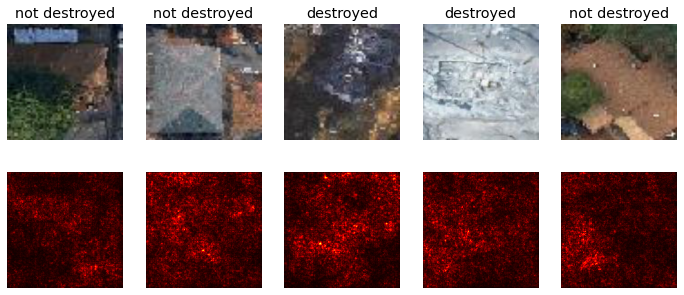

In [37]:
N = len(images)
for i in range(N):
    image = to_pil(images[i])
    plt.subplot(2, N, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.rc('font', size=12)
    if labels[i] == 0:
      plt.title('not destroyed')     
    else:
      plt.title('destroyed')
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
    plt.savefig('Saliency Maps.png')
plt.show()

Visualize effects of Random Noise

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ColorJitter(brightness=0.8, contrast=0.6, saturation=0.3, hue=0),
        transforms.ToTensor(),
    ])

train_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'train'),transform = data_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'val'),transform = data_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(FOLDERNAME,'test'),transform = data_transform)

In [0]:
loader_train = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers = 16) ## shuffle = True if sampler does not work 

loader_val = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers = 16)  ## shuffle = True

loader_test = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers = 16)

In [0]:
def get_random_images_wnoise(num):
    data = val_dataset
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, data.classes

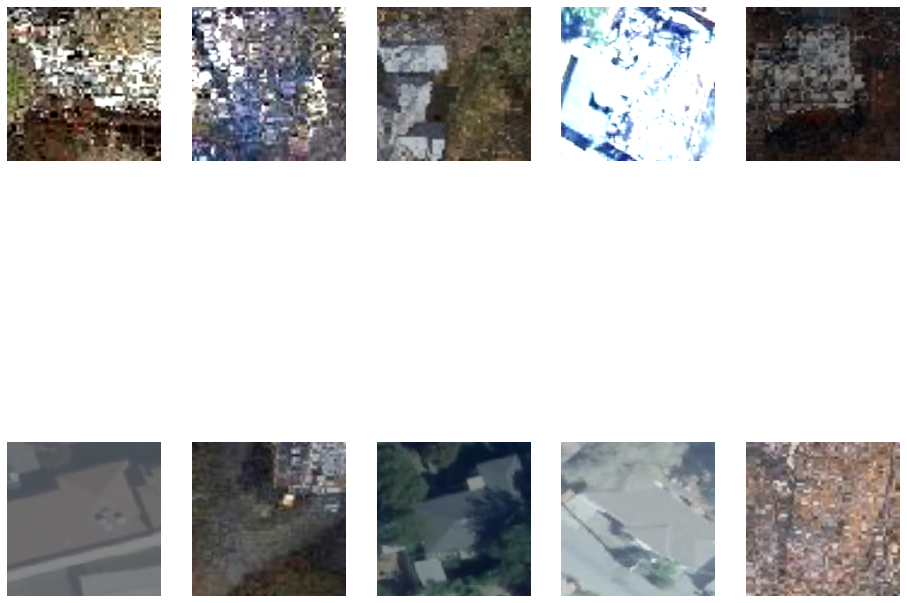

In [21]:
to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images_wnoise(10)
fig=plt.figure(figsize=(16, 16))

for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(2, len(images)/2, ii+1)
    fig.subplots_adjust(hspace=0.0, wspace=0.2)
    plt.axis('off')
    plt.imshow(image)
    #plt.savefig('Model Predictions.png')
plt.show()